# Levy Stable models of Stochastic Volatility
- https://pyro.ai/examples/stable.html

In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

pyro.enable_validation(True)

In [2]:
df = load_snp500()
dates = df.Date.to_numpy()
x = torch.tensor(df["Close"]).float()
x.shape

torch.Size([23116])

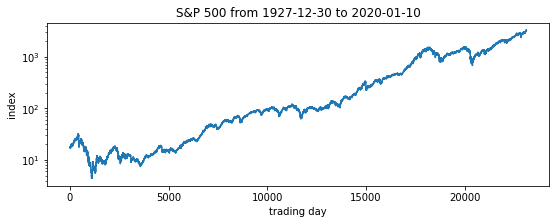

In [3]:
pyplot.figure(figsize=(9, 3))
pyplot.plot(x)
pyplot.yscale('log')
pyplot.ylabel("index")
pyplot.xlabel("trading day")
pyplot.title("S&P 500 from {} to {}".format(dates[0], dates[-1]));

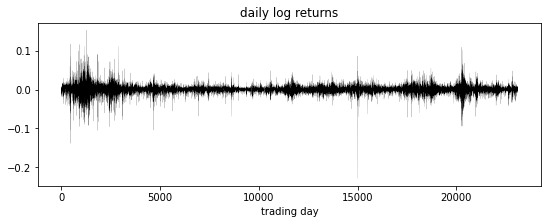

In [4]:
pyplot.figure(figsize=(9, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1)
pyplot.title("daily log returns")
pyplot.xlabel("trading day");

Text(0.5, 1.0, 'Empirical distribution.  mean=0.000226, std=0.0119')

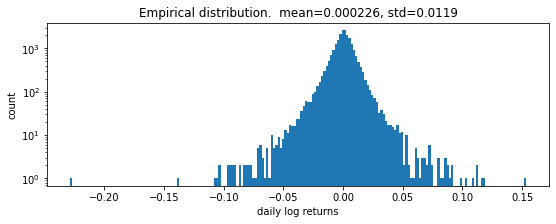

In [5]:
pyplot.figure(figsize=(9, 3))
pyplot.hist(r.numpy(), bins=200)
pyplot.yscale('log')
pyplot.ylabel("count")
pyplot.xlabel("daily log returns")
pyplot.title("Empirical distribution.  mean={:0.3g}, std={:0.3g}".format(r.mean(), r.std()))

In [6]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)
    return prediction

step 0 loss = 8.961662292480469
step 20 loss = 4.850587844848633
step 40 loss = 1.5544664859771729
step 60 loss = 1.6165744066238403
step 80 loss = 1.537550449371338
step 100 loss = 1.3704826831817627
step 120 loss = 1.3326966762542725
step 140 loss = 1.2837563753128052
step 160 loss = 1.2797116041183472
step 180 loss = 1.2778178453445435
step 200 loss = 1.282110333442688
--------------------
loc = 0.0004461
scale = 0.008593
stability = 1.977
CPU times: user 2.14 s, sys: 446 ms, total: 2.59 s
Wall time: 1.96 s


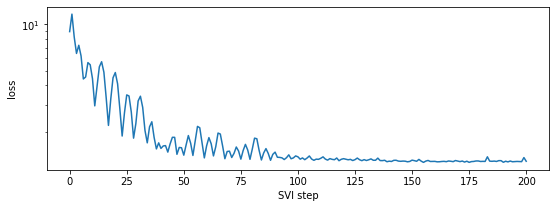

In [7]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

print("-" * 20)
pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.yscale("log")
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.squeeze().item()))

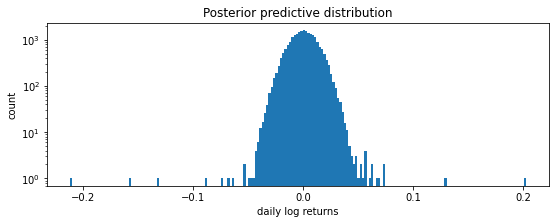

In [8]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(9, 3))
pyplot.hist(samples.numpy(), bins=200)
pyplot.yscale("log")
pyplot.xlabel("daily log returns")
pyplot.ylabel("count")
pyplot.title("Posterior predictive distribution");

In [19]:
def model(data):
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_0 = pyro.sample("h_0", dist.Normal(0, 1)).unsqueeze(-1)
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1)).unsqueeze(-1)
    v = pyro.sample("v", dist.Normal(0, 1).expand(data.shape).to_event(1))
    log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=-1))
    sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

    # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(0, 2)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h).to_event(1),
                obs=data)

In [20]:
reparam_model = poutine.reparam(model, {"v": DiscreteCosineReparam(),
                                        "r": StableReparam()})

step 0 loss = 3.21761e+08
step 50 loss = 7.30577
step 100 loss = 0.304864
step 150 loss = -0.55216
step 200 loss = -1.31887
step 250 loss = -0.349047
step 300 loss = -2.25893
step 350 loss = -2.24614
step 400 loss = -2.54599
step 450 loss = -2.47364
step 500 loss = -2.69784
--------------------
h_0 = -0.1447 ± 0.02439
r_loc = 0.05605 ± 0.004082
r_skew = -0.0001009 ± 0.001979
r_stability = 1.532 ± 0.01031
sigma = 0.288 ± 0.002492
CPU times: user 19.1 s, sys: 4.84 s, total: 24 s
Wall time: 18.7 s


(-2.716117540747733, 20.0)

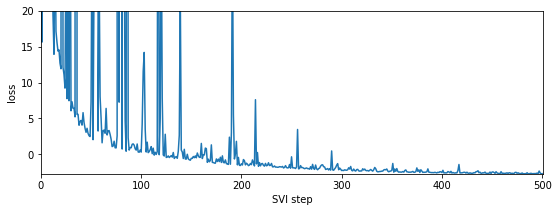

In [21]:
%%time
pyro.clear_param_store()
num_steps = 501
optim = ClippedAdam({"lr": 0.05, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps)})
guide = AutoDiagonalNormal(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))

print("-" * 20)
for name, (lb, ub) in sorted(guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.detach().squeeze().item()
        ub = ub.detach().squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
pyplot.xlim(0, len(losses))
pyplot.ylim(min(losses), 20)

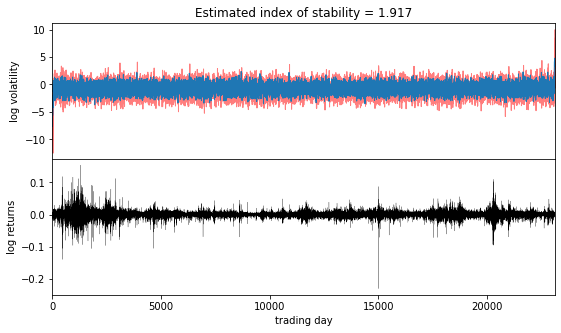

In [17]:
fig, axes = pyplot.subplots(2, figsize=(9, 5), sharex=True)
pyplot.subplots_adjust(hspace=0)
axes[1].plot(r, "k", lw=0.2)
axes[1].set_ylabel("log returns")
axes[1].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=20, parallel=True)(r)
log_h = pred["log_h"]
axes[0].plot(log_h.median(0).values, lw=1)
axes[0].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(2, dim=0).values,
                     log_h.kthvalue(18, dim=0).values,
                     color='red', alpha=0.5)
axes[0].set_ylabel("log volatility")

stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability))
axes[1].set_xlabel("trading day");

In [18]:
import matplotlib.pyplot as plt
pred["r"].shape

torch.Size([20, 23115])

In [27]:
samples = poutine.uncondition(reparam_model)(r).detach()
pyplot.figure(figsize=(9, 3))
pyplot.hist(samples.numpy(), bins=200)
pyplot.yscale("log")
pyplot.xlabel("daily log returns")
pyplot.ylabel("count")
pyplot.title("Posterior predictive distribution");

AttributeError: 'NoneType' object has no attribute 'detach'